# Simple demo of a three, identical multi-component buildings in a multi-agent env

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from gridworld import MultiAgentEnv, MultiComponentEnv
from gridworld.agents.buildings import FiveZoneROMThermalEnergyEnv
from gridworld.agents.pv import PVEnv
from gridworld.agents.energy_storage import EnergyStorageEnv
from gridworld.agents.vehicles import EVChargingEnv
from gridworld.distribution_system import OpenDSSSolver

%matplotlib inline

# Env configuration

In [5]:
# Start by defining the components of the building agent.
building = {
    "name": "building",
    "cls": FiveZoneROMThermalEnergyEnv,
    "config": {
        "rescale_spaces": False,
        "obs_config": {
            "zone_temp": (18, 34),
            "p_consumed": (-100, 100)
        }
    }
}

pv = {
    "name": "pv",
    "cls": PVEnv,
    "config": {
        "profile_csv": "pv_profile.csv",
        "scaling_factor": 400.,
        "rescale_spaces": False
    }
}

storage = {
    "name": "storage",
    "cls": EnergyStorageEnv,
    "config": {"rescale_spaces": False}
}

building_agent ={
    "name": "building",
    "bus": "675c",
    "cls": MultiComponentEnv,
    "config": {"components": [building, pv, storage]}
}


# Next, build the PV and EV charging envs
ev_agent = {
    "name": "ev-charging",
    "bus": "675c",
    "cls": EVChargingEnv,
    "config": {
        "num_vehicles": 100,
        "minutes_per_step": 5,
        "max_charge_rate_kw": 7.,
        "peak_threshold": 250.,
        "vehicle_multiplier": 2.,
        "rescale_spaces": False
    }
}

pv_agent = {
    "name": "pv",
    "bus": "675c",
    "cls": PVEnv,
    "config": {
        "profile_csv": "constant.csv",
        "scaling_factor": 400.0,
        "rescale_spaces": False,
        "grid_aware": True
    }
}


# Next, create the list of 3 agents to construct the multiagent env.
agents = [building_agent, ev_agent, pv_agent]

# Common configuration
common_config = {
    "start_time": "08-12-2020 00:00:00",
    "end_time": "08-13-2020 00:00:00",
    "control_timedelta": pd.Timedelta(300, "s")
}

# Power flow solver configuration
pf_config = {
    "cls": OpenDSSSolver,
    "config": {
        "feeder_file": "ieee_13_dss/IEEE13Nodeckt.dss",
        "loadshape_file": "ieee_13_dss/annual_hourly_load_profile.csv",
        "system_load_rescale_factor": 0.7,
    }
}

# Environment configuration
env_config = {
    "common_config": common_config,
    "pf_config": pf_config,
    "agents": agents
}

env = MultiAgentEnv(**env_config)

# Run the env with a random policy

In [8]:
env.reset()
done = {"__all__": False}
metas = []
states = []
while not done["__all__"]:
    action = {name: space.sample() for name, space in env.action_space.items()}
    obs, rew, done, meta = env.step(action)
    states.append(obs)
    metas.append(meta)

# Plot voltages

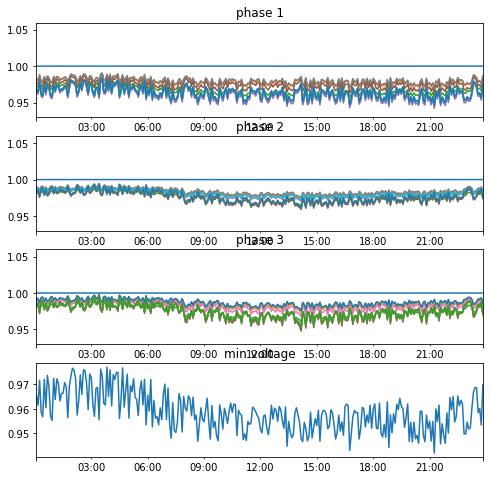

In [10]:
df = pd.DataFrame(env.history["voltage"], index=env.history["timestamp"])

fig, ax = plt.subplots(4)
fig.set_size_inches((8, 8))
for i in range(3):
    _ = df[[x for x in df.columns if x.startswith("6") and x.endswith(str(i+1))]].plot(
        ax=ax[i], legend=False, ylim=(0.93, 1.06), title="phase " + str(i+1))

_  = df.min(axis=1).plot(title="min voltage", ax=ax[i+1])